In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pickle
import random
import gzip
import json
import zstd
import polars as pl
import time

# No. of Different Videos Commented Daily by Each Author

It creates dataset in "data_type2" which contains normal users & suspicious users that commented on > 10 different videos on a day
- author: user id
- videos_comments: no. of videos commented on the day
- upload_date: date of the day

In [3]:
# Create filtered authors df (active users with at least 100 total comments in lifetime)
threshold_comments = 100
num_comments_authors_orignial = pl.read_csv("./data/num_comments_authors.tsv.gz", separator="\t")
active_users_df_polars = num_comments_authors_orignial.filter(pl.col("video_id") > threshold_comments)
active_users_df_polars = active_users_df_polars.select(["author"])
del num_comments_authors_orignial


In [35]:
%%time
# Load youtube videos metadata dataset (to get 'upload_date')
df_metadata_feather = pd.read_feather("./data/yt_metadata_helper.feather", columns=['display_id', 'upload_date'])
df_metadata_feather.rename(columns={"display_id":"video_id"}, inplace=True)

# Convert df_metadata_feather to a Polars DataFrame
df_metadata_polars = pl.from_pandas(df_metadata_feather).with_columns(
    pl.col("upload_date").dt.date().alias("upload_date")  
)

del df_metadata_feather # remove Pandas df from memory since not used

# Create dataset that contains only video_id and upload_date
df_metadata_polars.write_parquet("video_date.parquet", compression='zstd')

df_metadata_polars.head()

CPU times: user 42.1 s, sys: 17.1 s, total: 59.2 s
Wall time: 1min 8s


video_id,upload_date
str,date
"""SBqSc91Hn9g""",2016-09-28
"""UuugEl86ESY""",2016-09-28
"""oB4c-yvnbjs""",2016-09-28
"""ZaV-gTCMV8E""",2016-09-28
"""cGvL7AvMfM0""",2016-09-28


In [4]:
# Read dataset that contains video_id & upload_date
video_date = pl.read_parquet("video_date.parquet")
video_date

video_id,upload_date
str,date
"""SBqSc91Hn9g""",2016-09-28
"""UuugEl86ESY""",2016-09-28
"""oB4c-yvnbjs""",2016-09-28
"""ZaV-gTCMV8E""",2016-09-28
"""cGvL7AvMfM0""",2016-09-28
…,…
"""YQLoxwLpjSU""",2017-02-06
"""mINQHg1QBcg""",2017-02-06
"""x20aNOWh1yI""",2017-02-06


In [7]:
%%time
# Create dataset for # of videos commented by each author/user

import os
import time

i = 0
chunksize = 100_000_000
processed_rows= 0
start_time = time.time()  # Record the start time
file_path = f"suspicious_vid_commented_daily.parquet"

threshold = 10 # threshold for no. of videos commented daily

'''
NOTE: total_rows in youtube_comments.tsv.gz = 8_610_000_000
'''

cols = ["author", "video_id"]

for df in  pd.read_csv("./data/youtube_comments.tsv.gz", compression="infer", sep="\t", chunksize=chunksize, usecols=cols): # chunksize = # of rows
    print("\nprocessing df chunk...")

    df = pl.from_pandas(df)

    # filter active users (with at least 100 comments in lifetime)
    df = df.join(active_users_df_polars, on="author", how="inner")

    # Add upload_date by joining with video_date df
    df = df.join(video_date, on='video_id', how='left')  
    df = df[["author", "upload_date"]]

    q = (
        df
        .lazy()  # Convert to lazy frame
        .group_by(["author","upload_date"])
        .agg(pl.len().alias("videos_commented")) # count no. of videos commented on a day/date
    )

    df_polars = q.collect()

    # Identify all suspicious users with 'videos_commented' on a date above threshold 
    authors_above_threshold = (
        df_polars.lazy()
        .filter(pl.col("videos_commented") >= threshold)
        .select("author")
        .unique()
        .collect()
    )

    # Create a dataset containing random 10% sample of normal users (below threshold)
    df_polars_normal = df_polars.filter(~pl.col("author").is_in(authors_above_threshold["author"]))
    sampled_authors = df_polars_normal['author'].unique().sample(fraction=0.10)
    df_polars_normal = df_polars_normal.filter(pl.col('author').is_in(sampled_authors))
    # Save to disk
    df_polars_normal.write_parquet(f"./data_type2/normal_vids_commented_daily_{i+1}.parquet", compression='zstd')
    print(f"saved './data_type2/normal_vids_commented_daily_{i+1}.parquet'.")

    # Filter out rows for suspicious users i-e users who went above threshold at some date
    df_polars = df_polars.filter(pl.col("author").is_in(authors_above_threshold["author"]))
    # Save to disk
    df_polars.write_parquet(f"./data_type2/suspicious_vids_commented_daily_{i+1}.parquet", compression='zstd')
    print(f"saved './data_type2/suspicious_vids_commented_daily_{i+1}.parquet'. ")


    # Track the number of processed rows
    processed_rows += chunksize

    # Display progress
    print(f"iteration:{i+1}, processed_rows: {processed_rows:_}")
    i += 1

    current_time = time.time()     # Record the end time
    elapsed_time = current_time - start_time
    elapsed_hours = int(elapsed_time // 3600)
    elapsed_minutes = int((elapsed_time % 3600) // 60)
    elapsed_seconds = int(elapsed_time % 60)
    print(f"Elapsed time: {elapsed_hours:02}:{elapsed_minutes:02}:{elapsed_seconds:02}\n")
    



processing df chunk...
saved './data_type2/normal_vids_commented_daily_1.parquet'.
saved './data_type2/suspicious_vids_commented_daily_1.parquet'. 
iteration:1, processed_rows: 100_000_000
Elapsed time: 00:00:54


processing df chunk...
saved './data_type2/normal_vids_commented_daily_2.parquet'.
saved './data_type2/suspicious_vids_commented_daily_2.parquet'. 
iteration:2, processed_rows: 200_000_000
Elapsed time: 00:01:48


processing df chunk...
saved './data_type2/normal_vids_commented_daily_3.parquet'.
saved './data_type2/suspicious_vids_commented_daily_3.parquet'. 
iteration:3, processed_rows: 300_000_000
Elapsed time: 00:02:42


processing df chunk...
saved './data_type2/normal_vids_commented_daily_4.parquet'.
saved './data_type2/suspicious_vids_commented_daily_4.parquet'. 
iteration:4, processed_rows: 400_000_000
Elapsed time: 00:03:37


processing df chunk...
saved './data_type2/normal_vids_commented_daily_5.parquet'.
saved './data_type2/suspicious_vids_commented_daily_5.parque

In [8]:
# Sanity Check for Suspicious Users - Print stats & top 'videos_commented' values for each author
df_sorted = df_polars.sort(["author", "videos_commented"], descending=True)
top_5_per_author = df_sorted.group_by("author").agg([
    pl.col("videos_commented").head(5)
])
print("\nNormal Users: ",df_polars["videos_commented"].describe())
print(top_5_per_author)

NameError: name 'df_polars' is not defined

In [8]:
# Sanity Check For Normal Users - Print stats & top 'videos_commented' values for each author
df_sorted = df_polars_normal.sort(["author", "videos_commented"], descending=True)
top_5_per_author = df_sorted.group_by("author").agg([
    pl.col("videos_commented").head(5)
])
print("\nSuspiciouse Users: ",df_polars_normal["videos_commented"].describe())
print(top_5_per_author)


Suspiciouse Users:  shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 2.245888e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 1.358998   │
│ std        ┆ 0.818816   │
│ min        ┆ 1.0        │
│ 25%        ┆ 1.0        │
│ 50%        ┆ 1.0        │
│ 75%        ┆ 1.0        │
│ max        ┆ 9.0        │
└────────────┴────────────┘
shape: (13_469, 2)
┌─────────┬──────────────────┐
│ author  ┆ videos_commented │
│ ---     ┆ ---              │
│ i64     ┆ list[u32]        │
╞═════════╪══════════════════╡
│ 6694653 ┆ [7, 6, … 6]      │
│ 6694274 ┆ [4, 3, … 3]      │
│ 6693858 ┆ [9, 7, … 5]      │
│ 6693799 ┆ [5, 2, … 2]      │
│ 6693721 ┆ [6, 4, … 3]      │
│ …       ┆ …                │
│ 2117    ┆ [6, 5, … 5]      │
│ 2090    ┆ [9, 6, … 5]      │
│ 1465    ┆ [8, 7, … 6]      │
│ 1306    ┆ [7, 5, … 4]      │
│ 821     ┆ [3, 3, … 3]      │
└─────────┴──────────────────┘

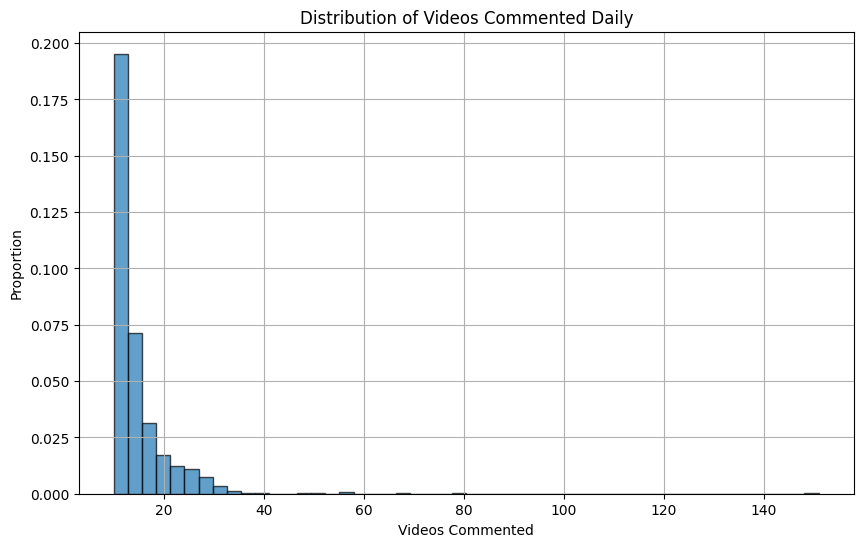

In [9]:
import matplotlib.pyplot as plt

# Plot the distribution of "videos_commented"
plt.figure(figsize=(10, 6))
plt.hist(all_daily_results["videos_commented"].to_list(), bins=50, edgecolor='black', alpha=0.7, density=True)
plt.title('Distribution of Videos Commented Daily')
plt.xlabel('Videos Commented')
plt.ylabel('Proportion')
plt.grid(True)
plt.show()


In [10]:
# Count the unique authors in the DataFrame
unique_authors_count = all_daily_results["author"].n_unique()

# Print the count of unique authors
print(f"Number of unique authors: {unique_authors_count}")


Number of unique authors: 496
